<h1 id="title">Predicting Motor Vehicle Accident Severity in Seattle, Washington by Oversampling Minority Classes to Achieve Balanced Training Data<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7fb3e04c9310>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 11.486563144950196 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.351442493963987 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "PERSONCOUNT",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.600920474971645 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.230920629925095 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PEDCOUNT         171872 non-null  int64   
 3   PEDCYLCOUNT      171872 non-null  int64   
 4   VEHCOUNT         171872 non-null  int64   
 5   INJURIES         171872 non-null  int64   
 6   SERIOUSINJURIES  171872 non-null  int64   
 7   FATALITIES       171872 non-null  int64   
 8   WEATHER          171872 non-null  category
 9   ROADCOND         171872 non-null  category
 10  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(6)
memory usage: 10.0 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.688218246912584 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class_1_size =', class_1_size)
print('class_2_size =', class_2_size)
print('class_2b_size =', class_2b_size)
print('class_3_size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority_class_size =', minority_class_size)

class_1_size = 113082
class_2_size = 55521
class_2b_size = 2941
class_3_size = 328

minority_class_size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.717012009001337 seconds.


<h2 id='sample_size_class_3'>Sample all Classes Equally to Create a Balanced Training Set<\h2>

In [34]:
# This parameter determines what fraction of the minority class's data are reserved for testing.
test_size_ratio = .5

# Using train/test splits, set aside part of the data for testing.
df_class_1_train_pre_sampling, df_class_1_test = train_test_split(df_class_1, test_size=test_size_ratio, random_state=seed)
df_class_2_train_pre_sampling, df_class_2_test = train_test_split(df_class_2, test_size=test_size_ratio, random_state=seed)
df_class_2b_train_pre_sampling, df_class_2b_test = train_test_split(df_class_2b, test_size=test_size_ratio, random_state=seed)
df_class_3_train_pre_sampling, df_class_3_test = train_test_split(df_class_3, test_size=test_size_ratio, random_state=seed)

In [35]:
# Build a balanced training set by sampling the pre_sampling training data equally:

# Set a sampling parameter to control the amount of oversampling for the minority class.
# Oversampling requires this parameter to be greater than 1.
# If this parameter is less than or equal to 1, then oversampling will not occur.
sampling_ratio = 4

# Set the replace parameter of the sample method based on the sampling ratio.
# If the sampling_ratio > 1, sample with replacement.
# Otherwise, sample without replacement.
sample_with_replacement = bool(sampling_ratio > 1)
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 3 with replacement: %s' % (sample_with_replacement))

# Sample the minority class's training set based on the sampling parameter and store the sample for later concatenation.
df_class_3_train = df_class_3_train_pre_sampling.sample(frac=sampling_ratio, replace=sample_with_replacement, axis='index', random_state=seed)

# Store the size of the minority class's training set.
class_3_train_size = df_class_3_train.shape[0]

# Take samples of the other classes' training data, where the sample size taken is equal to the size of the minority class's training set.
# If the sample size to be taken exceeds the number of samples in the class's training data, sample with replacement.

# Sampling for class 2b.
sample_with_replacement = bool(class_3_train_size > df_class_2b_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2b with replacement: %s' % (sample_with_replacement))
df_class_2b_train = df_class_2b_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 2.
sample_with_replacement = bool(class_3_train_size > df_class_2_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2 with replacement: %s' % (sample_with_replacement))
df_class_2_train = df_class_2_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 1.
sample_with_replacement = bool(class_3_train_size > df_class_1_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 1 with replacement: %s' % (sample_with_replacement))
df_class_1_train = df_class_1_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

Sample class 3 with replacement: True
Sample class 2b with replacement: False
Sample class 2 with replacement: False
Sample class 1 with replacement: False


In [36]:
# Make a balanced, unshuffled training set by concatenating the equal sized samples of the training sets for each class.
df_train_balanced_not_shuffled = pd.concat([df_class_1_train, df_class_2_train, df_class_2b_train, df_class_3_train], axis='index')

# Make a not necessarily balanced testing set by concatenating the testing sets for each class.
df_test_not_shuffled = pd.concat([df_class_1_test, df_class_2_test, df_class_2b_test, df_class_3_test], axis='index')

In [37]:
# Shuffle the training set and store it for tuning hyper-parameters and for cross-validation.
df_train = shuffle(df_train_balanced_not_shuffled, random_state=seed)

# Shuffle the unbalanced DataFrame and store it for validation and for comparing the models.
df_test = shuffle(df_test_not_shuffled, random_state=seed)

In [38]:
# Verify the training DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     656
2b    656
2     656
1     656
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_train.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2624 entries, 72322 to 43792
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  2624 non-null   category
 1   PEDCOUNT       2624 non-null   int64   
 2   PEDCYLCOUNT    2624 non-null   int64   
 3   VEHCOUNT       2624 non-null   int64   
 4   WEATHER        2624 non-null   category
 5   ROADCOND       2624 non-null   category
 6   LIGHTCOND      2624 non-null   category
dtypes: category(4), int64(3)
memory usage: 93.8 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [42]:
y = df_train["SEVERITYCODE"].to_numpy()

In [43]:
print_elapsed_time(notebook_start_time)

Elapsed time is 24.22368969093077 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [44]:
# Create a OneHotEncoder and fit it to the features.
# The fit is performed on the data set before the any test/train splits.
# The data will be encoded as a sparse matrix, the default behavior.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='error')
encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
#encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.3454758730949834 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x2_0'
 'x2_1' 'x2_2' 'x3_0' 'x3_1' 'x3_2' 'x3_3' 'x3_4' 'x3_5' 'x3_6' 'x3_7'
 'x3_8' 'x3_9' 'x3_10' 'x3_11' 'x3_12' 'x3_13' 'x3_14' 'x3_15'
 'x4_Blowing Sand/Dirt' 'x4_Clear' 'x4_Fog/Smog/Smoke' 'x4_Other'
 'x4_Overcast' 'x4_Partly Cloudy' 'x4_Raining' 'x4_Severe Crosswind'
 'x4_Sleet/Hail/Freezing Rain' 'x4_Snowing' 'x5_Dry' 'x5_Ice' 'x5_Oil'
 'x5_Other' 'x5_Sand/Mud/Dirt' 'x5_Snow/Slush' 'x5_Standing Water'
 'x5_Wet' 'x6_Dark - No Street Lights' 'x6_Dark - Street Lights Off'
 'x6_Dark - Street Lights On' 'x6_Dark - Unknown Lighting' 'x6_Dawn'
 'x6_Daylight' 'x6_Dusk' 'x6_Other']


In [45]:
type(X)

scipy.sparse.csr.csr_matrix

In [46]:
X.shape

(2624, 62)

In [47]:
y.shape

(2624,)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 25.11330738500692 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 20.317112 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 45.64585503493436 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 2.390918 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 48.20342730090488 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10

# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_pipeline = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)

# Use only odd numbers of neighbors to avoid ties.
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_weighted']
grid_search_cv = GridSearchCV(k_neighbors_pipeline, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_weighted', cv=number_of_folds, verbose=50, pre_dispatch=2**10, error_score='raise',\
                              return_train_score=False)

grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=1024, refit='recall_weighted',
             scoring=['recall_weighted'], verbose=50)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 176.934151 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=133, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=133, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 133
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 3.868482 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 229.37888551596552 seconds.


## Test the Models and Compare their Performance

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
#df_categorical.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85937 entries, 184164 to 109788
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SEVERITYCODE     85937 non-null  category
 1   COLLISIONTYPE    85937 non-null  category
 2   PEDCOUNT         85937 non-null  int64   
 3   PEDCYLCOUNT      85937 non-null  int64   
 4   VEHCOUNT         85937 non-null  int64   
 5   INJURIES         85937 non-null  int64   
 6   SERIOUSINJURIES  85937 non-null  int64   
 7   FATALITIES       85937 non-null  int64   
 8   WEATHER          85937 non-null  category
 9   ROADCOND         85937 non-null  category
 10  LIGHTCOND        85937 non-null  category
dtypes: category(5), int64(6)
memory usage: 5.0 MB


In [60]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     56541
2     27761
2b     1471
3       164
Name: SEVERITYCODE, Length: 4, dtype: int64


In [61]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657935464
2    0.323038970
2b   0.017117191
3    0.001908375
Name: SEVERITYCODE, Length: 4, dtype: float64


In [62]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
# print("Transforming full data set's feature set using OneHotEncoder...")
# X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
# X = encoder.transform(X)
print('Transforming features using OneHotEncoder...')
X_test = df_test.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X_test = encoder.transform(X_test)
print("Encoding completed in", elapsed_time(start_time), "seconds.")

Transforming features using OneHotEncoder...
Encoding completed in 0.4130931879626587 seconds.


In [63]:
y_test = df_test['SEVERITYCODE'].to_numpy()

In [64]:
X_test.shape

(85937, 62)

In [65]:
y_test.shape

(85937,)

In [66]:
print_elapsed_time(notebook_start_time)

Elapsed time is 230.76974724791944 seconds.


In [67]:
# Report statistics of the models built for each fold of the cross-validation.
print('Logistic Regression Cross-validation Scores:')
print()
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

Logistic Regression Cross-validation Scores:

fit_time: mean = 2.401646, std = 0.277254
fit_time :[2.8362844  3.00050378 2.33135986 2.32121301 2.20059109 2.07752967
 2.17352939 2.29873109 2.41376901 2.36294484]

score_time: mean = 0.113708, std = 0.030927
score_time :[0.10188627 0.06731701 0.14458609 0.1602664  0.13552952 0.09042215
 0.12440014 0.06311178 0.13512206 0.11443615]

test_f1_macro: mean = 0.473913, std = 0.037067
test_f1_macro :[0.50663477 0.51402715 0.54381868 0.44603378 0.47791955 0.46461294
 0.43820887 0.41165    0.47422447 0.46199997]

test_f1_weighted: mean = 0.473833, std = 0.037432
test_f1_weighted :[0.50686515 0.51404321 0.54456727 0.44663357 0.47760449 0.46463859
 0.43721833 0.41072349 0.47396191 0.46207629]

test_neg_log_loss: mean = -1.115464, std = 0.040140
test_neg_log_loss :[-1.06131417 -1.12490831 -1.04545845 -1.15945927 -1.0980971  -1.11208061
 -1.13375752 -1.16869337 -1.16131093 -1.08955887]

test_precision_macro: mean = 0.498025, std = 0.037970
test_precis

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.852760  0.504890  0.634258     56541
           2   0.409010  0.538958  0.465077     27761
          2b   0.054859  0.205303  0.086583      1471
           3   0.009349  0.591463  0.018408       164

    accuracy                       0.510932     85937
   macro avg   0.331495  0.460153  0.301081     85937
weighted avg   0.694144  0.510932  0.569056     85937



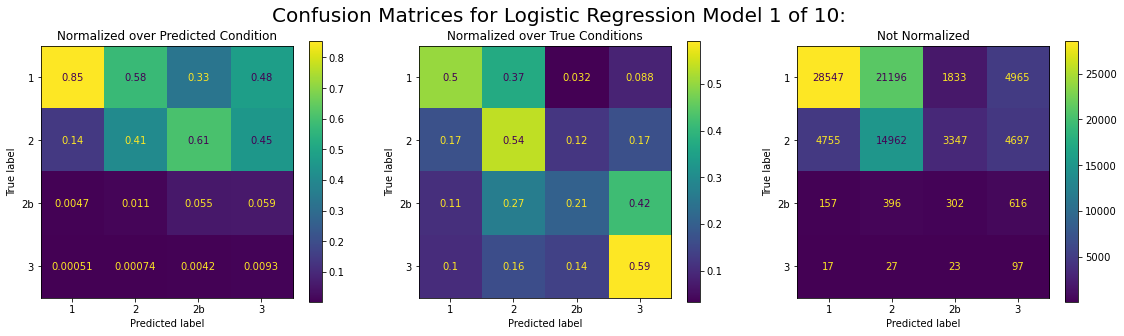

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.865487  0.489556  0.625374     56541
           2   0.411386  0.508123  0.454666     27761
          2b   0.038845  0.256968  0.067488      1471
           3   0.009361  0.567073  0.018418       164

    accuracy                       0.491721     85937
   macro avg   0.331270  0.455430  0.291486     85937
weighted avg   0.703011  0.491721  0.559521     85937



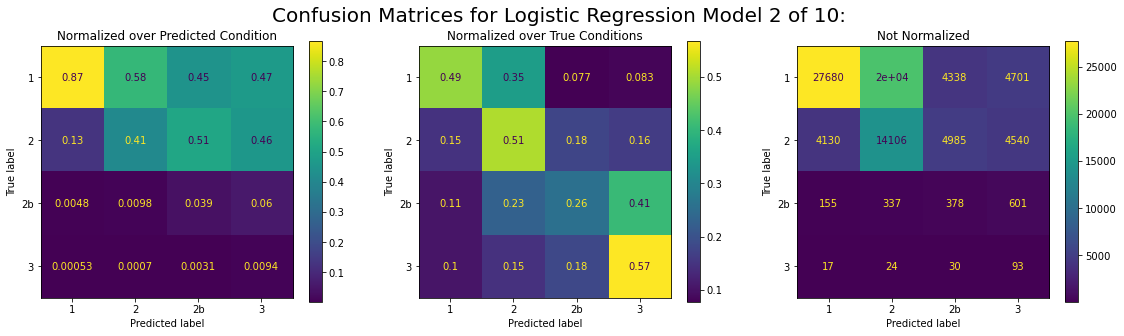

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.877262  0.458747  0.602453     56541
           2   0.409314  0.566694  0.475316     27761
          2b   0.043601  0.240653  0.073827      1471
           3   0.009169  0.548780  0.018036       164

    accuracy                       0.490057     85937
   macro avg   0.334837  0.453719  0.292408     85937
weighted avg   0.710170  0.490057  0.551219     85937



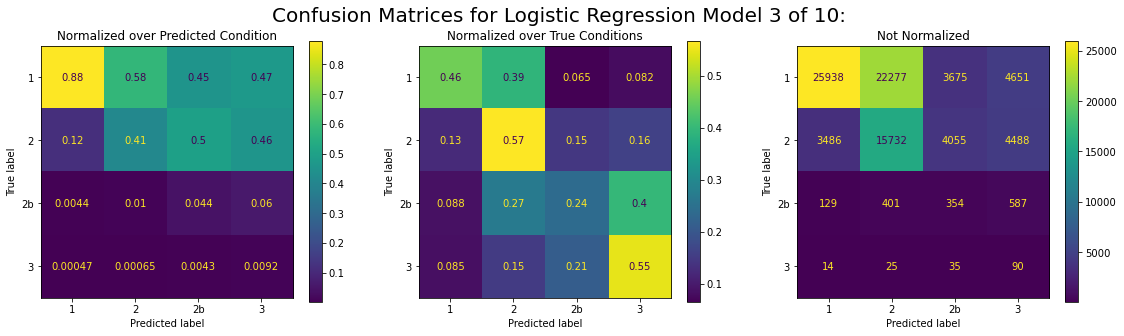

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.880945  0.452415  0.597817     56541
           2   0.409382  0.566478  0.475285     27761
          2b   0.041147  0.242012  0.070335      1471
           3   0.009152  0.548780  0.018004       164

    accuracy                       0.485844     85937
   macro avg   0.335156  0.452421  0.290360     85937
weighted avg   0.712573  0.485844  0.548099     85937



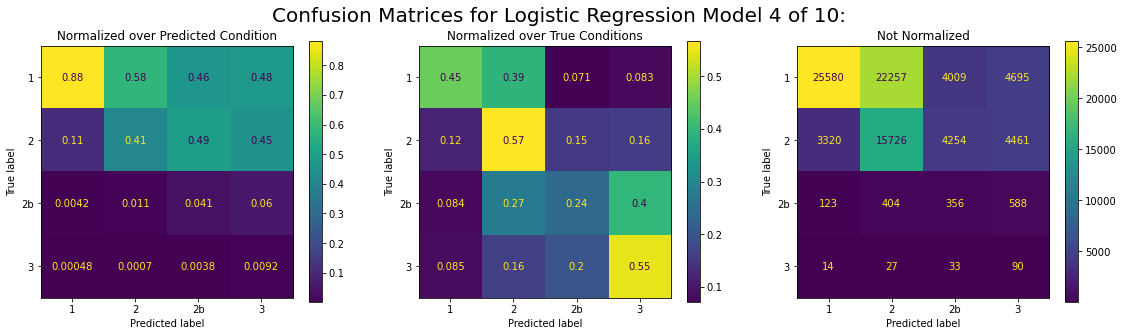

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.879695  0.448630  0.594219     56541
           2   0.408891  0.559922  0.472634     27761
          2b   0.040346  0.240653  0.069107      1471
           3   0.009406  0.591463  0.018517       164

    accuracy                       0.481294     85937
   macro avg   0.334585  0.460167  0.288619     85937
weighted avg   0.711579  0.481294  0.544855     85937



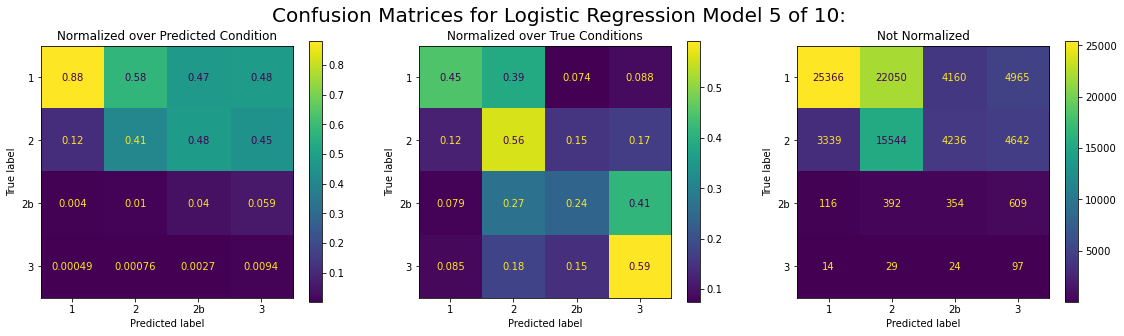

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.884562  0.430696  0.579320     56541
           2   0.403146  0.531825  0.458630     27761
          2b   0.033909  0.259007  0.059967      1471
           3   0.008911  0.573171  0.017549       164

    accuracy                       0.460698     85937
   macro avg   0.332632  0.448675  0.278866     85937
weighted avg   0.712814  0.460698  0.530371     85937



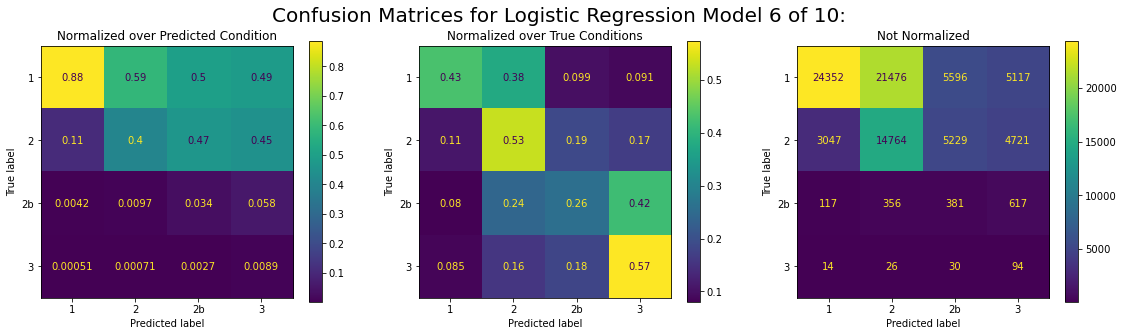

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.858581  0.494685  0.627707     56541
           2   0.407832  0.548864  0.467952     27761
          2b   0.052407  0.216859  0.084414      1471
           3   0.009282  0.560976  0.018261       164

    accuracy                       0.507558     85937
   macro avg   0.332025  0.455346  0.299584     85937
weighted avg   0.697551  0.507558  0.565637     85937



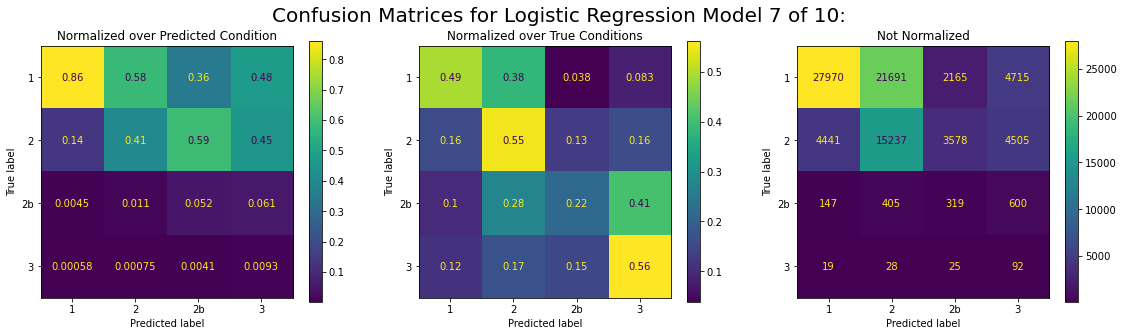

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.877421  0.453476  0.597927     56541
           2   0.409118  0.563092  0.473912     27761
          2b   0.040934  0.242012  0.070024      1471
           3   0.009277  0.554878  0.018249       164

    accuracy                       0.485460     85937
   macro avg   0.334188  0.453365  0.290028     85937
weighted avg   0.710166  0.485460  0.547723     85937



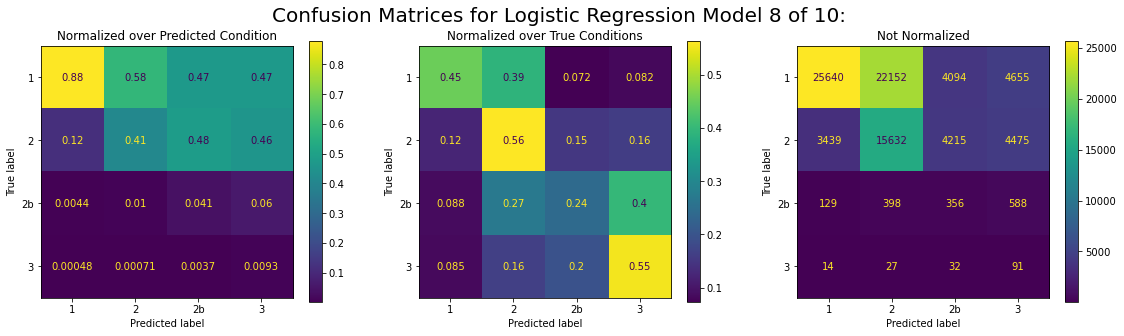

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.867297  0.485135  0.622221     56541
           2   0.408606  0.559238  0.472200     27761
          2b   0.052119  0.225697  0.084683      1471
           3   0.009150  0.554878  0.018004       164

    accuracy                       0.504765     85937
   macro avg   0.334293  0.456237  0.299277     85937
weighted avg   0.703531  0.504765  0.563404     85937



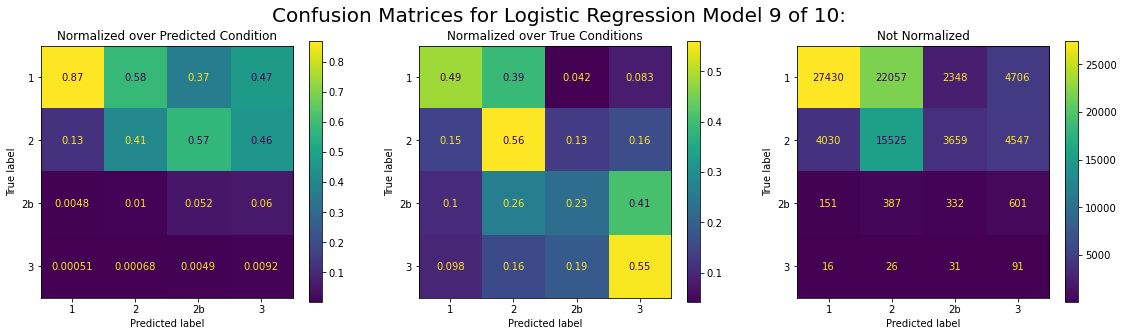

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.863395  0.486037  0.621953     56541
           2   0.408318  0.557329  0.471327     27761
          2b   0.052432  0.216179  0.084395      1471
           3   0.009063  0.560976  0.017838       164

    accuracy                       0.504591     85937
   macro avg   0.333302  0.455130  0.298878     85937
weighted avg   0.700876  0.504591  0.562941     85937



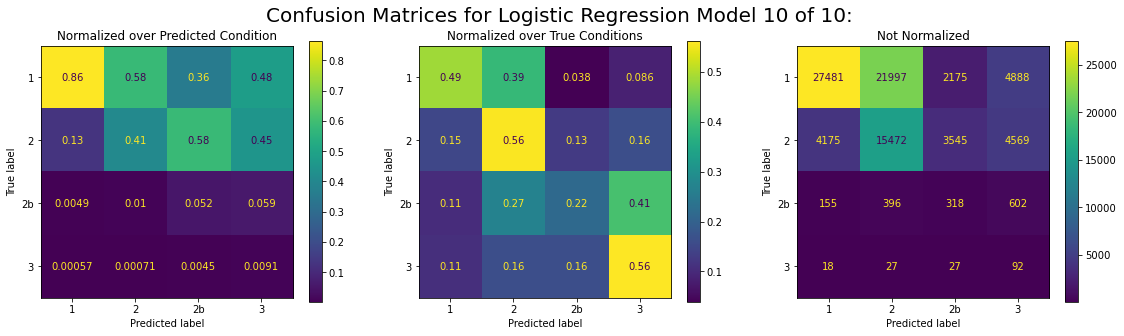

In [68]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [69]:
print_elapsed_time(notebook_start_time)

Elapsed time is 378.68768458790146 seconds.


In [70]:
# Report statistics of the models built for each fold of the cross-validation.
print('Support Vector Machine Cross-validation Scores:')
print()
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

Support Vector Machine Cross-validation Scores:

fit_time: mean = 0.314086, std = 0.076447
fit_time :[0.3860445  0.36580443 0.35434842 0.3926568  0.3501358  0.39763212
 0.23902774 0.2490983  0.20217824 0.20393014]

score_time: mean = 0.118760, std = 0.046613
score_time :[0.18912005 0.12842607 0.1307981  0.16759109 0.14329147 0.15832281
 0.07611489 0.05375743 0.09464288 0.04553485]

test_f1_macro: mean = 0.467473, std = 0.033473
test_f1_macro :[0.50744432 0.49307514 0.51509948 0.42297036 0.47629467 0.4642251
 0.43522516 0.41374649 0.49091623 0.45573099]

test_f1_weighted: mean = 0.467405, std = 0.033730
test_f1_weighted :[0.50755076 0.49304881 0.51592172 0.42360188 0.47603075 0.46427378
 0.43432296 0.41281255 0.49068516 0.45580504]

test_precision_macro: mean = 0.495517, std = 0.035920
test_precision_macro :[0.52549912 0.50947809 0.56627306 0.44834091 0.51176784 0.4885271
 0.4593603  0.44222197 0.5060764  0.49762228]

test_precision_weighted: mean = 0.495469, std = 0.036071
test_precisi

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.868091  0.484427  0.621843     56541
           2   0.408784  0.581391  0.480043     27761
          2b   0.061634  0.175391  0.091214      1471
           3   0.009052  0.591463  0.017831       164

    accuracy                       0.510665     85937
   macro avg   0.336890  0.458168  0.302733     85937
weighted avg   0.704273  0.510665  0.565800     85937



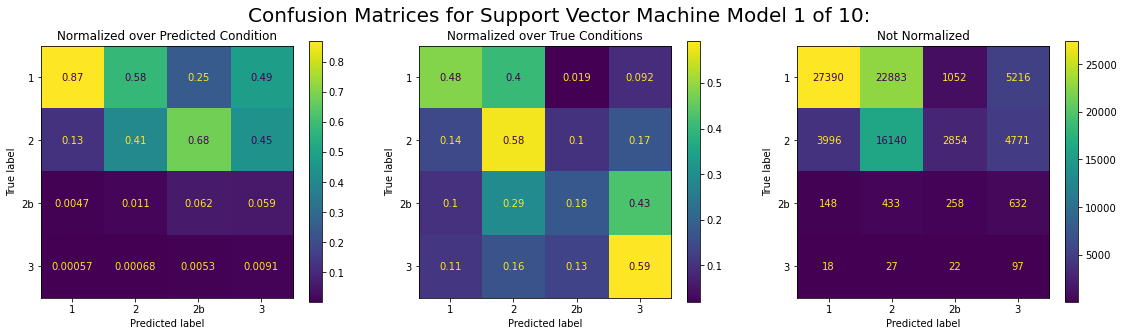

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.868282  0.484074  0.621600     56541
           2   0.412387  0.511365  0.456573     27761
          2b   0.037617  0.243372  0.065162      1471
           3   0.008975  0.573171  0.017672       164

    accuracy                       0.488940     85937
   macro avg   0.331815  0.452995  0.290252     85937
weighted avg   0.705152  0.488940  0.557613     85937



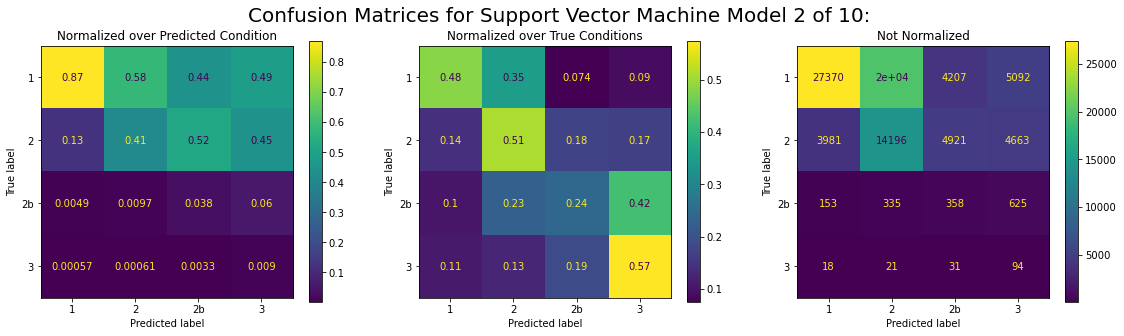

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.874415  0.469305  0.610793     56541
           2   0.409501  0.572278  0.477395     27761
          2b   0.051154  0.194426  0.080997      1471
           3   0.008658  0.591463  0.017065       164

    accuracy                       0.498097     85937
   macro avg   0.335932  0.456868  0.296563     85937
weighted avg   0.708486  0.498097  0.557499     85937



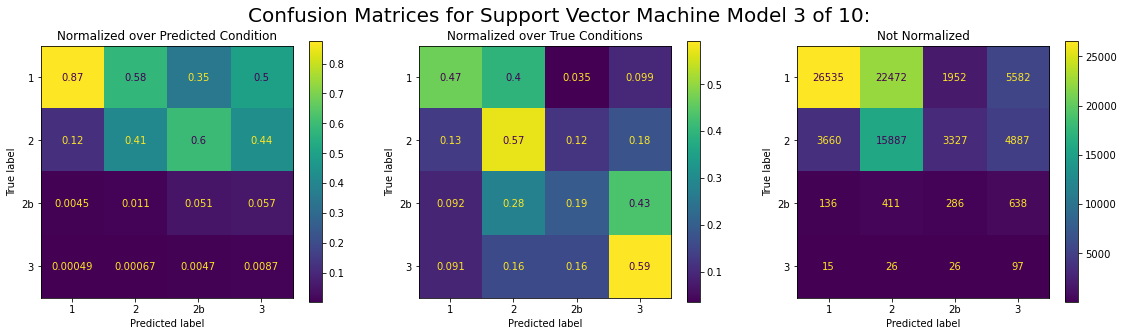

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.875791  0.470137  0.611833     56541
           2   0.410950  0.525053  0.461047     27761
          2b   0.039772  0.242012  0.068317      1471
           3   0.008509  0.579268  0.016771       164

    accuracy                       0.484180     85937
   macro avg   0.333755  0.454118  0.289492     85937
weighted avg   0.709664  0.484180  0.552684     85937



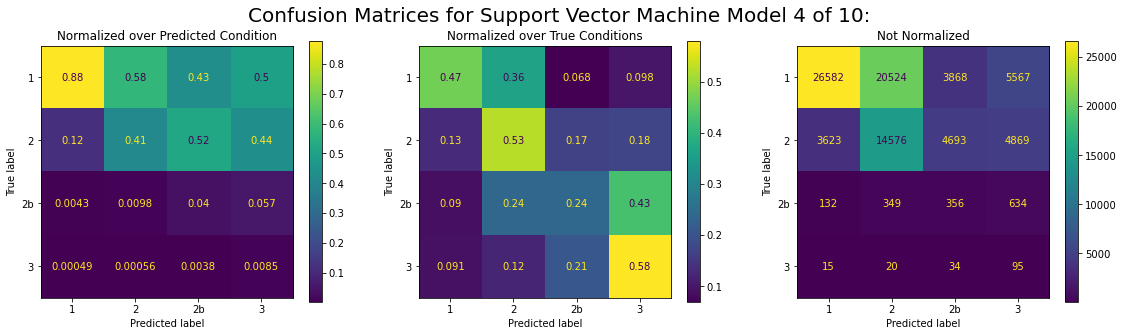

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.887361  0.436108  0.584805     56541
           2   0.408439  0.555095  0.470606     27761
          2b   0.037873  0.233855  0.065189      1471
           3   0.008644  0.597561  0.017042       164

    accuracy                       0.471392     85937
   macro avg   0.335579  0.455655  0.284410     85937
weighted avg   0.716433  0.471392  0.537936     85937



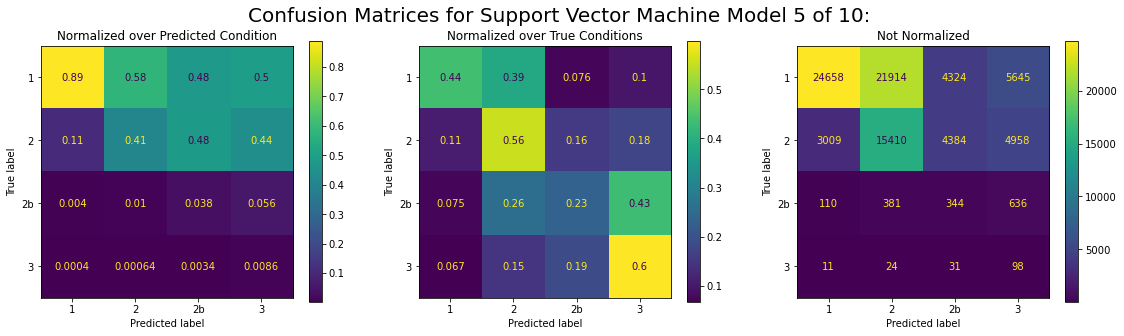

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.890459  0.421393  0.572067     56541
           2   0.403605  0.527431  0.457284     27761
          2b   0.032969  0.260367  0.058527      1471
           3   0.008684  0.597561  0.017119       164

    accuracy                       0.453227     85937
   macro avg   0.333929  0.451688  0.276249     85937
weighted avg   0.716825  0.453227  0.525138     85937



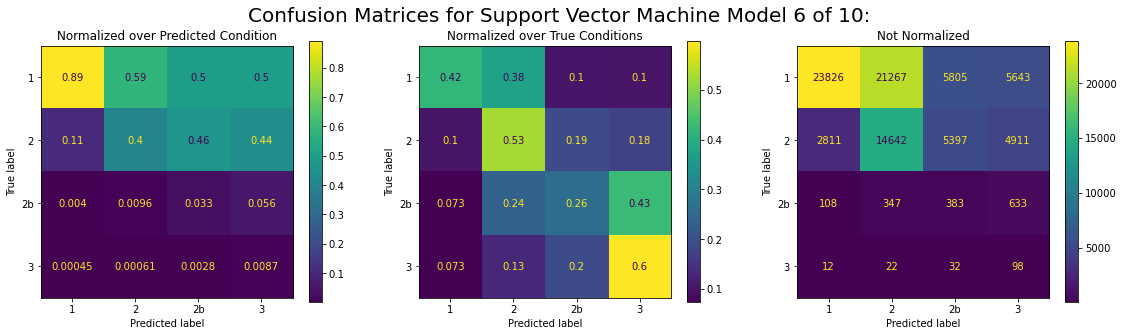

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.872885  0.472560  0.613166     56541
           2   0.408254  0.579050  0.478879     27761
          2b   0.057680  0.189667  0.088459      1471
           3   0.008637  0.585366  0.017023       164

    accuracy                       0.502333     85937
   macro avg   0.336864  0.456661  0.299382     85937
weighted avg   0.707188  0.502333  0.559667     85937



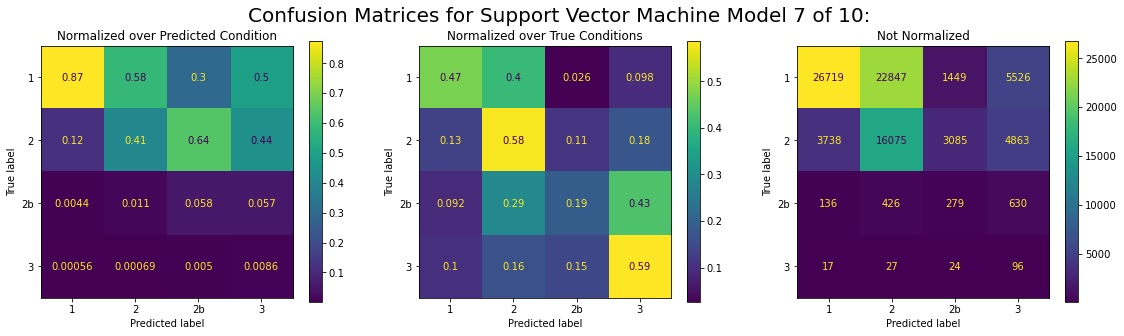

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.886383  0.438637  0.586860     56541
           2   0.408610  0.584309  0.480914     27761
          2b   0.041454  0.203943  0.068902      1471
           3   0.008528  0.573171  0.016807       164

    accuracy                       0.481934     85937
   macro avg   0.336244  0.450015  0.288371     85937
weighted avg   0.715906  0.481934  0.542682     85937



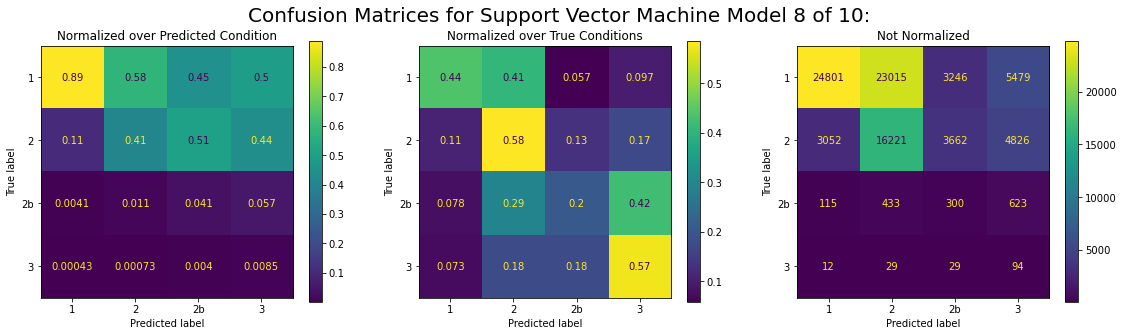

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.873646  0.474965  0.615376     56541
           2   0.409023  0.555816  0.471253     27761
          2b   0.050456  0.233175  0.082960      1471
           3   0.008336  0.542683  0.016421       164

    accuracy                       0.497073     85937
   macro avg   0.335365  0.451660  0.296502     85937
weighted avg   0.707813  0.497073  0.558562     85937



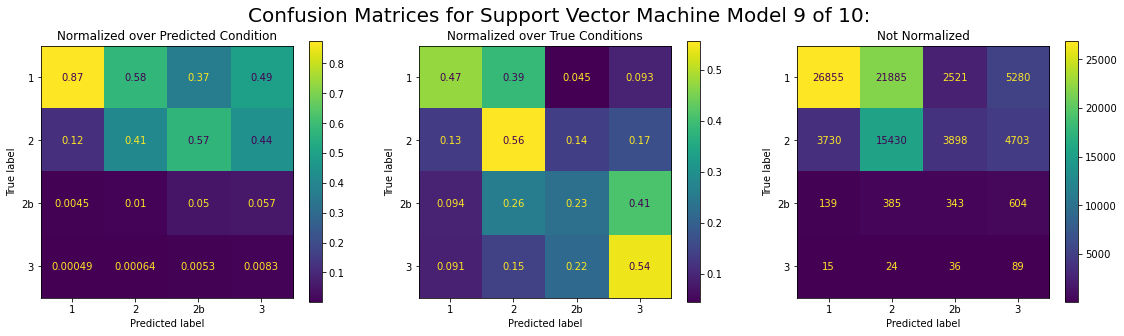

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.873719  0.470508  0.611641     56541
           2   0.408612  0.583841  0.480757     27761
          2b   0.056874  0.180829  0.086532      1471
           3   0.008523  0.579268  0.016799       164

    accuracy                       0.502368     85937
   macro avg   0.336932  0.453612  0.298932     85937
weighted avg   0.707838  0.502368  0.559236     85937



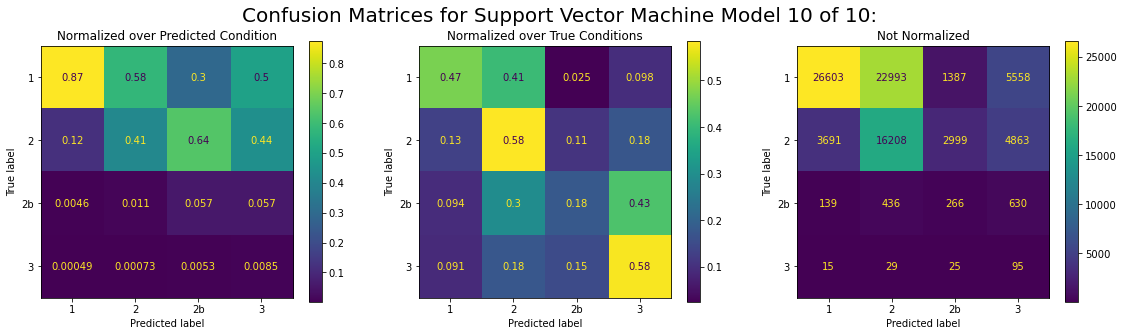

In [71]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [72]:
print_elapsed_time(notebook_start_time)

Elapsed time is 528.6503469779855 seconds.


In [73]:
# Report statistics of the models built for each fold of the cross-validation.
print('k-Nearest Neighbors Cross-validation Scores:')
print()
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

k-Nearest Neighbors Cross-validation Scores:

fit_time: mean = 0.044210, std = 0.017527
fit_time :[0.05755758 0.05301356 0.07931781 0.06236768 0.03460002 0.04249024
 0.02911162 0.03620958 0.02736068 0.02006626]

score_time: mean = 0.690691, std = 0.273414
score_time :[1.07767248 0.89798164 1.10156035 0.98665738 0.40199161 0.50515676
 0.56112695 0.42421865 0.47081518 0.47972751]

test_f1_macro: mean = 0.473998, std = 0.031204
test_f1_macro :[0.53517426 0.46733313 0.50016815 0.4136507  0.46441984 0.49443508
 0.45577975 0.45483849 0.46302057 0.49116199]

test_f1_weighted: mean = 0.474043, std = 0.031262
test_f1_weighted :[0.53546764 0.46758915 0.50090597 0.41458388 0.46399877 0.49430219
 0.45483639 0.45394085 0.46335369 0.49145033]

test_neg_log_loss: mean = -2.485039, std = 0.420899
test_neg_log_loss :[-2.3377929  -3.03568724 -2.47651752 -2.20786583 -2.03627199 -3.14680165
 -2.79210416 -2.84576106 -1.92434855 -2.0472431 ]

test_precision_macro: mean = 0.478239, std = 0.033583
test_precis

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.815244  0.518898  0.634158     56541
           2   0.403983  0.440654  0.421522     27761
          2b   0.037650  0.242692  0.065188      1471
           3   0.007658  0.475610  0.015072       164

    accuracy                       0.488812     85937
   macro avg   0.316134  0.419463  0.283985     85937
weighted avg   0.667539  0.488812  0.554548     85937



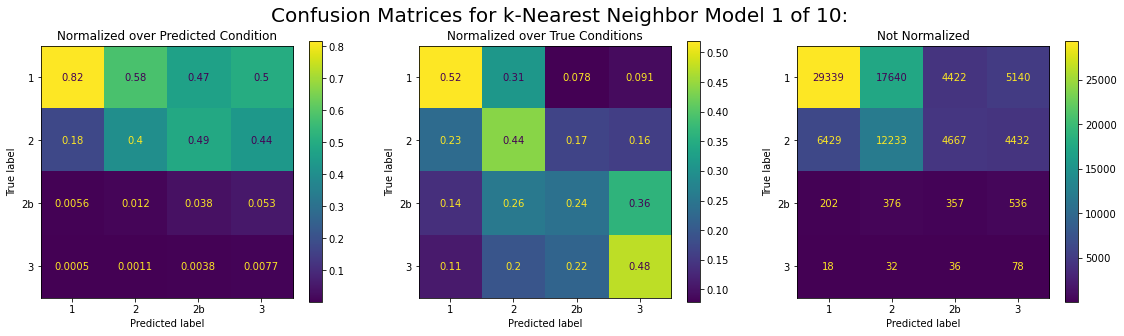

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.829692  0.499054  0.623236     56541
           2   0.409888  0.453622  0.430648     27761
          2b   0.033944  0.248131  0.059719      1471
           3   0.007463  0.475610  0.014695       164

    accuracy                       0.480038     85937
   macro avg   0.320247  0.419104  0.282074     85937
weighted avg   0.678889  0.480038  0.550215     85937



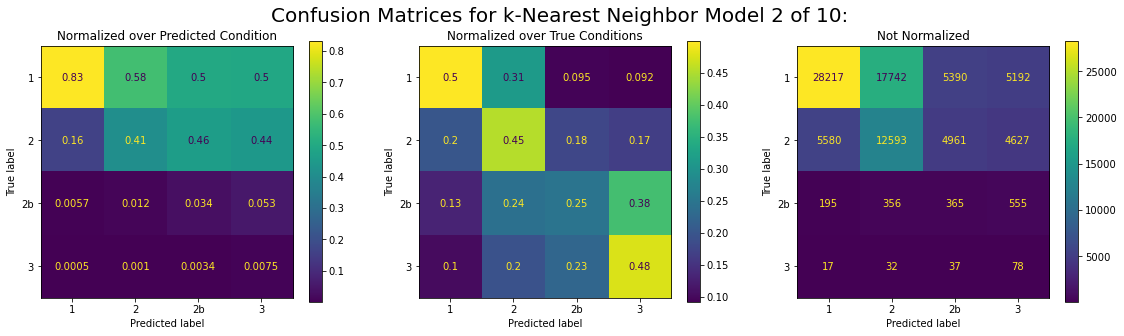

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.804997  0.567004  0.665359     56541
           2   0.411835  0.399878  0.405768     27761
          2b   0.038610  0.238613  0.066465      1471
           3   0.007749  0.475610  0.015249       164

    accuracy                       0.507220     85937
   macro avg   0.315797  0.420276  0.288210     85937
weighted avg   0.663350  0.507220  0.570009     85937



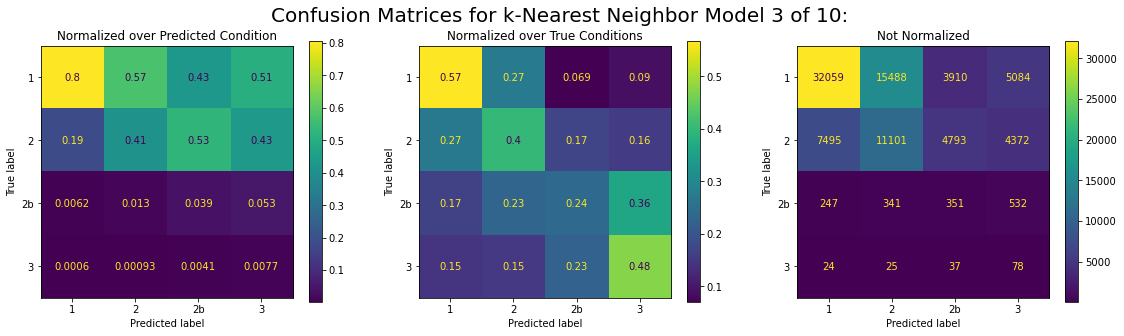

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.812366  0.530960  0.642188     56541
           2   0.414011  0.430460  0.422075     27761
          2b   0.033623  0.236574  0.058878      1471
           3   0.007781  0.463415  0.015304       164

    accuracy                       0.493327     85937
   macro avg   0.316945  0.415352  0.284611     85937
weighted avg   0.668817  0.493327  0.559902     85937



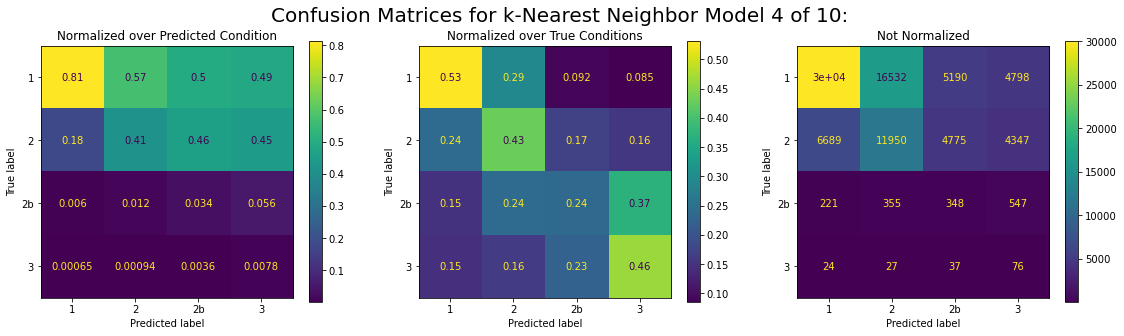

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.825401  0.500911  0.623462     56541
           2   0.404669  0.428983  0.416471     27761
          2b   0.031125  0.253569  0.055444      1471
           3   0.007639  0.475610  0.015036       164

    accuracy                       0.473393     85937
   macro avg   0.317208  0.414768  0.277603     85937
weighted avg   0.674332  0.473393  0.545712     85937



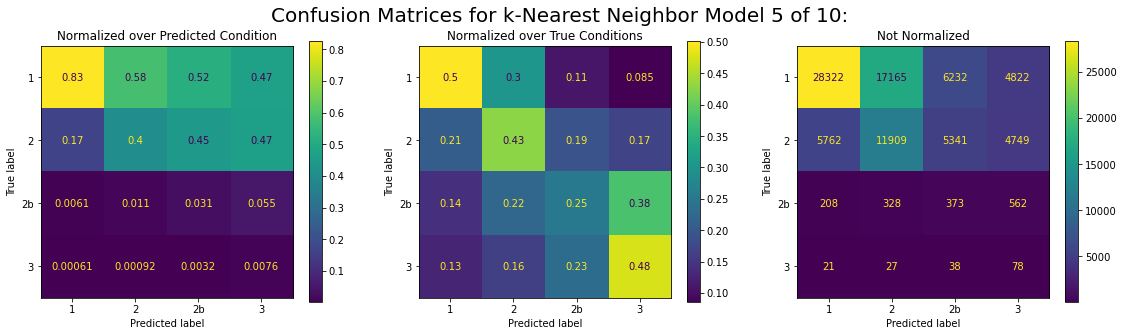

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.825461  0.493589  0.617775     56541
           2   0.403877  0.433774  0.418292     27761
          2b   0.032471  0.273963  0.058061      1471
           3   0.007676  0.463415  0.015102       164

    accuracy                       0.470449     85937
   macro avg   0.317371  0.416185  0.277307     85937
weighted avg   0.674138  0.470449  0.542604     85937



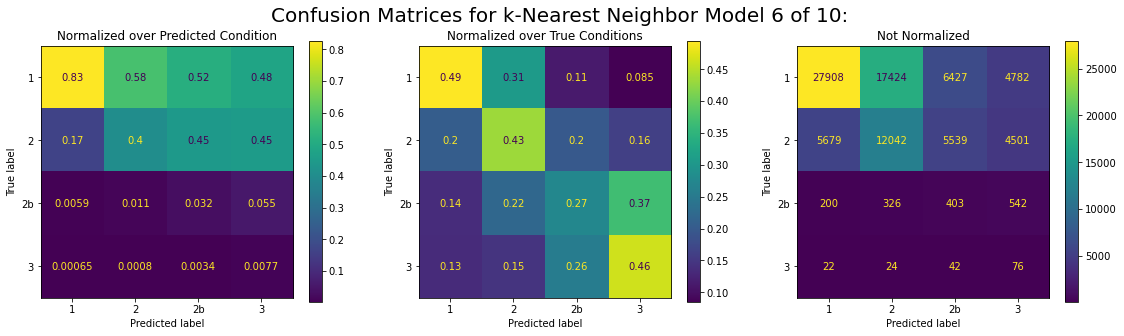

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.826282  0.525017  0.642067     56541
           2   0.406179  0.452721  0.428189     27761
          2b   0.040585  0.241332  0.069485      1471
           3   0.007460  0.469512  0.014686       164

    accuracy                       0.496701     85937
   macro avg   0.320127  0.422146  0.288607     85937
weighted avg   0.675561  0.496701  0.561978     85937



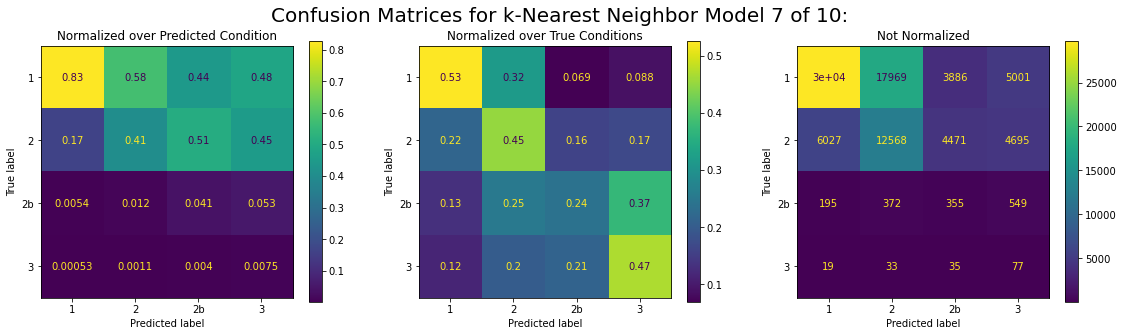

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.827181  0.491077  0.616283     56541
           2   0.399634  0.447931  0.422406     27761
          2b   0.032884  0.253569  0.058218      1471
           3   0.007870  0.475610  0.015484       164

    accuracy                       0.473044     85937
   macro avg   0.316892  0.417047  0.278098     85937
weighted avg   0.673907  0.473044  0.542954     85937



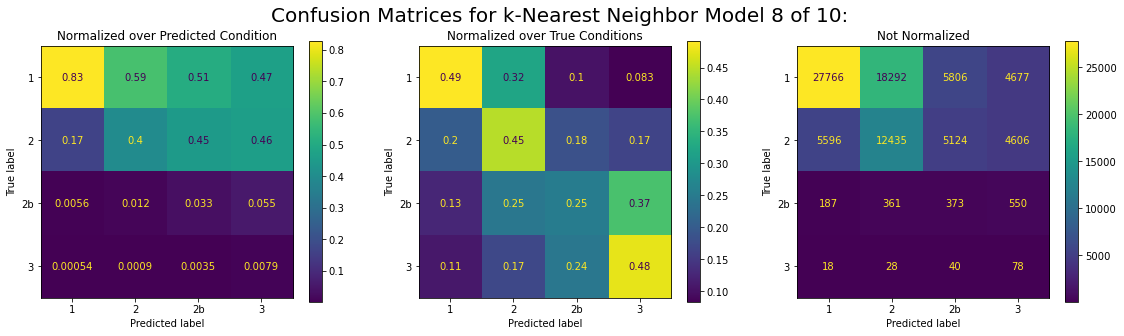

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.809663  0.553952  0.657831     56541
           2   0.414247  0.408487  0.411346     27761
          2b   0.032902  0.219579  0.057229      1471
           3   0.008150  0.500000  0.016039       164

    accuracy                       0.501135     85937
   macro avg   0.316240  0.420504  0.285611     85937
weighted avg   0.667102  0.501135  0.566702     85937



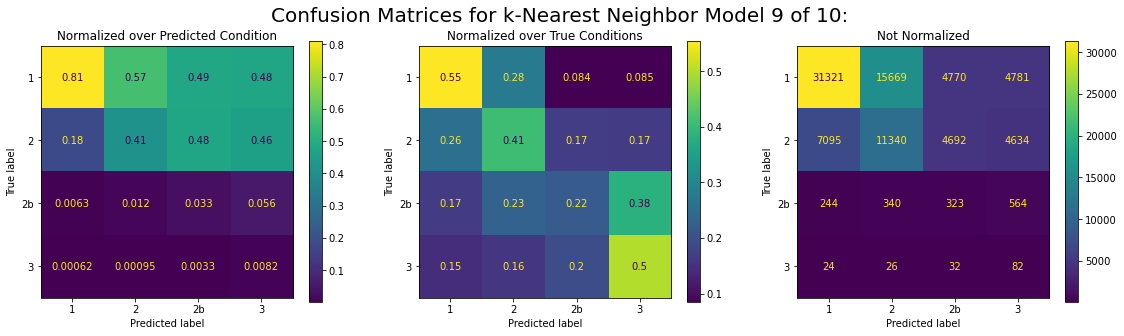

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.818522  0.518827  0.635094     56541
           2   0.396962  0.435899  0.415521     27761
          2b   0.037359  0.233855  0.064426      1471
           3   0.007496  0.475610  0.014759       164

    accuracy                       0.487078     85937
   macro avg   0.315085  0.416048  0.282450     85937
weighted avg   0.667423  0.487078  0.553211     85937



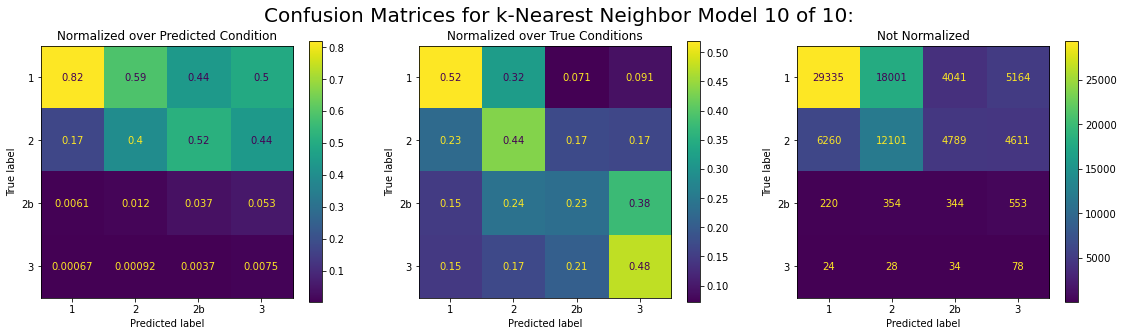

In [74]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [75]:
print('All reports and graphics generated in %f seconds.' % (elapsed_time(t0)))

All reports and graphics generated in 2411.469640 seconds.


In [76]:
print_elapsed_time(notebook_start_time)

Elapsed time is 2641.0564367349725 seconds.
